In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Взять картинку с большим количеством деталей

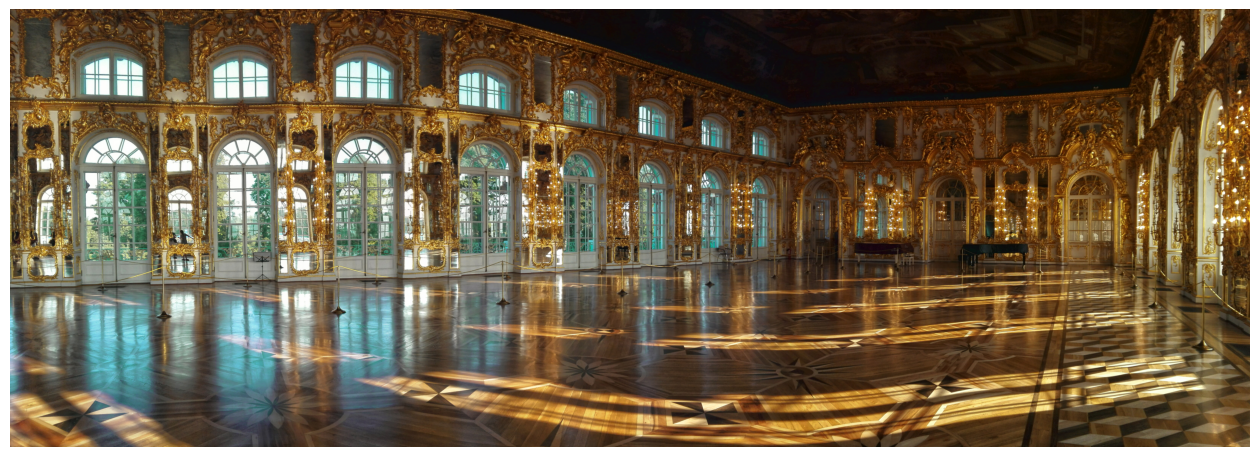

In [ ]:
image = cv2.imread('/content/drive/MyDrive/OAD/IMG_20180817_181602.jpg')

# display
plt.figure(figsize=(16, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Поделить картинку на 3 части с перекрытием в 50% в отдельные картинки

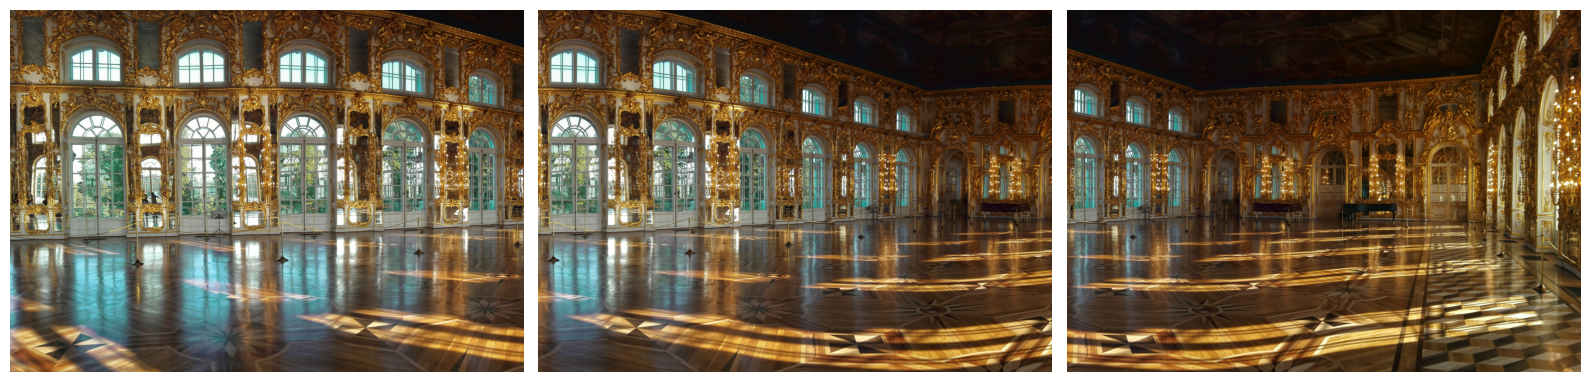

In [13]:
height, width = image.shape[:2]

overlap = width // 4

left_start = 0
left_end = 2 * overlap

middle_start = overlap
middle_end = middle_start + 2 * overlap

right_start = 2 * overlap
right_end = right_start + 2 * overlap

left_part = image[:, left_start:left_end]
middle_part = image[:, middle_start:middle_end]
right_part = image[:, right_start:right_end]

left_part_rgb = cv2.cvtColor(left_part, cv2.COLOR_BGR2RGB)
middle_part_rgb = cv2.cvtColor(middle_part, cv2.COLOR_BGR2RGB)
right_part_rgb = cv2.cvtColor(right_part, cv2.COLOR_BGR2RGB)

# display
plt.figure(figsize=(16, 10))

plt.subplot(1, 3, 1)
plt.imshow(left_part_rgb)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(middle_part_rgb)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(right_part_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

Повернуть левую и правую картинку

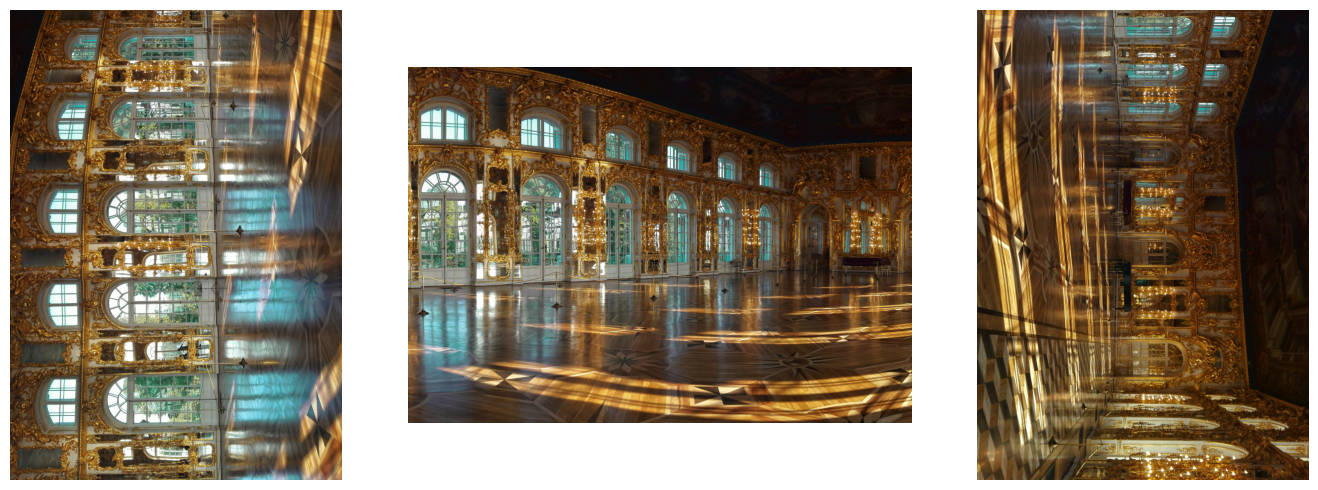

In [14]:
left_part_rotated = cv2.rotate(left_part, cv2.ROTATE_90_COUNTERCLOCKWISE)
right_part_rotated = cv2.rotate(right_part, cv2.ROTATE_90_CLOCKWISE)

# display
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(left_part_rotated, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(middle_part, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(right_part_rotated, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

Выровнять обратно левые и правые картинки

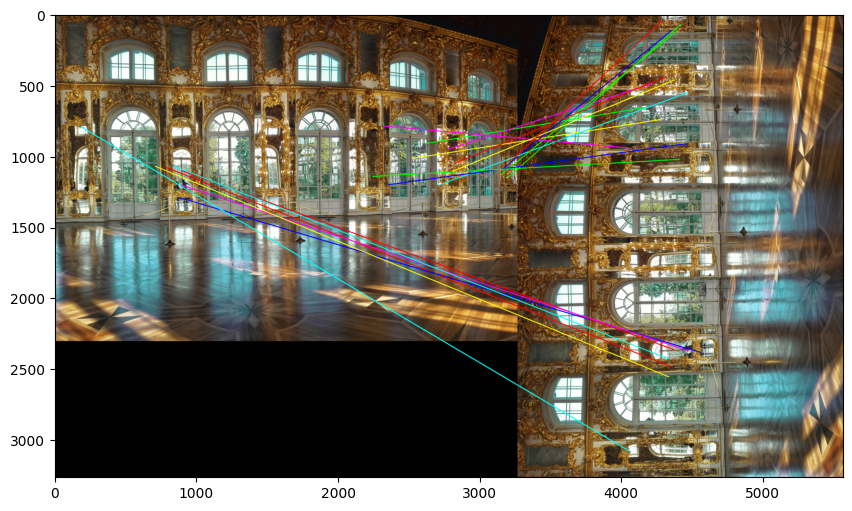

In [15]:
# key point detection
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(left_part, None)
kp2, des2 = orb.detectAndCompute(left_part_rotated, None)

# comparison of key points
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

img_matches = cv2.drawMatches(cv2.cvtColor(left_part, cv2.COLOR_BGR2RGB), kp1, cv2.cvtColor(left_part_rotated, cv2.COLOR_BGR2RGB), kp2, matches[:20], None,
                               flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (0, 255, 255), (255, 0, 255), (255, 255, 0)]

for i, match in enumerate(matches[:20]):
    pt1 = tuple(np.round(kp1[match.queryIdx].pt).astype(int))
    pt2 = tuple(np.round(kp2[match.trainIdx].pt).astype(int) + np.array([left_part.shape[1], 0]))
    color = colors[i % len(colors)]
    cv2.line(img_matches, pt1, pt2, color, 5)

plt.figure(figsize=(12, 6))
plt.imshow(img_matches)

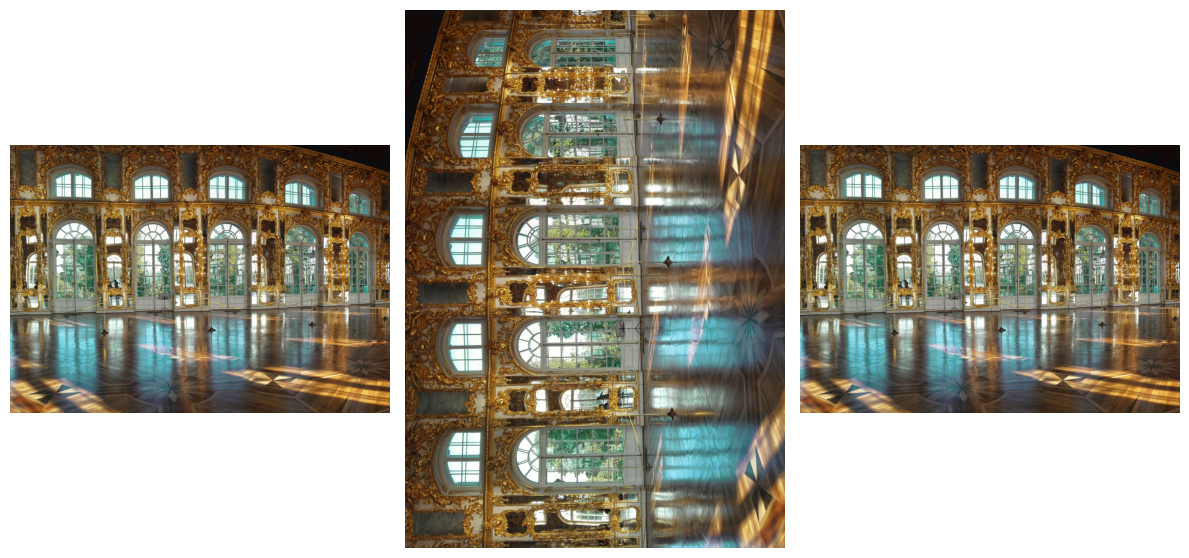

In [16]:
# preparing points for homography
pts_src = np.float32([kp1[m.queryIdx].pt for m in matches[:10]]).reshape(-1, 1, 2)
pts_dst = np.float32([kp2[m.trainIdx].pt for m in matches[:10]]).reshape(-1, 1, 2)

homography, status = cv2.findHomography(pts_dst, pts_src)

height, width = left_part.shape[:2]
left_part_original = cv2.warpPerspective(left_part_rotated, homography, (width, height))

# display
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(left_part, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(left_part_rotated, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(left_part_original, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
# key point detection
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(right_part, None)
kp2, des2 = orb.detectAndCompute(right_part_rotated, None)

# comparison of key points
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# preparing points for homography
pts_src = np.float32([kp1[m.queryIdx].pt for m in matches[:10]]).reshape(-1, 1, 2)
pts_dst = np.float32([kp2[m.trainIdx].pt for m in matches[:10]]).reshape(-1, 1, 2)

homography, status = cv2.findHomography(pts_dst, pts_src)

height, width = right_part.shape[:2]
right_part_original = cv2.warpPerspective(right_part_rotated, homography, (width, height))

Склеить получившиеся картинки в одну панораму

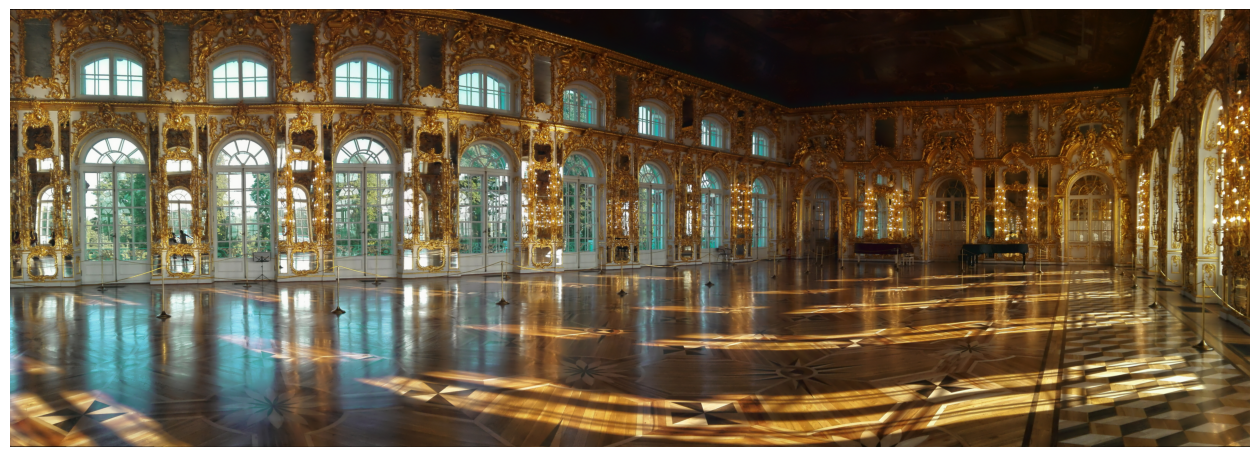

In [18]:
stitcher = cv2.Stitcher_create()

images = [left_part_original, middle_part, right_part_original]

status, stitched_image = stitcher.stitch(images)

if status == cv2.Stitcher_OK:
    cv2.imwrite('stitched_image.jpg', stitched_image)

    plt.figure(figsize=(16, 10))
    plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))

    plt.axis('off')
    plt.show()